In [1]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 300
K = 3
D = 2

## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN1 = 8
STAT_SIZE = 8
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 20
NUM_EPOCHS = 25
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
PATH = 'ag-sis-mu-cf-z'

gpu = torch.device('cuda:1')

In [3]:
Xs = torch.from_numpy(np.load('rings_dataset/obs.npy')).float()
# STATES = torch.from_numpy(np.load('rings_dataset/states.npy')).float()
# OBS_MU = torch.from_numpy(np.load('rings_dataset/obs_mu.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Enc_mu(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden1=NUM_HIDDEN1,
                       num_stats=STAT_SIZE,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        
        self.neural_stats = nn.Sequential(
            nn.Linear(K+D, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, num_stats),
            nn.Tanh())
        self.mean_mu = nn.Sequential(
            nn.Linear(num_stats+D, int(0.5 * num_stats+ 0.5 * D)),
            nn.Tanh(),
            nn.Linear(int(0.5 * num_stats + 0.5 * D), D))
        
        self.mean_log_sigma = nn.Sequential(
            nn.Linear(num_stats+D, int(0.5 * num_stats+ 0.5 * D)),
            nn.Tanh(),
            nn.Linear(int(0.5 * num_stats + 0.5 * D), D))

        self.prior_mu = torch.zeros((K, D))
        self.prior_sigma = torch.ones((K, D)) * 4.0
        if CUDA:
            self.prior_mu = self.prior_mu.cuda().to(gpu)
            self.prior_sigma = self.prior_sigma.cuda().to(gpu)
        
    def forward(self, obs, states, sample_size, batch_size):
        neural_stats = self.neural_stats(torch.cat((obs, states), -1))
        _, _, _, stat_size = neural_stats.shape
        cluster_size = states.sum(-2)  
        cluster_size[cluster_size == 0.0] = 1.0 # S * B * K
        neural_stats_expand = neural_stats.unsqueeze(-1).repeat(1, 1, 1, 1, K).transpose(-1, -2) ## S * B * N * K * STAT_SIZE
        states_expand = states.unsqueeze(-1).repeat(1, 1, 1, 1, stat_size) ## S * B * N * K * STAT_SIZE
        sum_stats = (states_expand * neural_stats_expand).sum(2) ## S * B * K * STAT_SIZE
        mean_stats = sum_stats / cluster_size.unsqueeze(-1)
        
        c1 = torch.cat((self.prior_mu[0].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,0,:]), -1)
        c2 = torch.cat((self.prior_mu[1].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,1,:]), -1)
        c3 = torch.cat((self.prior_mu[2].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,2,:]), -1)
        #
        q_mu_c1 = self.mean_mu(c1)
        q_mu_c2 = self.mean_mu(c2)
        q_mu_c3 = self.mean_mu(c3)
        q_sigma_c1 = self.mean_log_sigma(c1).exp()
        q_sigma_c2 = self.mean_log_sigma(c2).exp()
        q_sigma_c3 = self.mean_log_sigma(c3).exp() 
        q_mu = torch.cat((q_mu_c1.unsqueeze(-2), q_mu_c2.unsqueeze(-2), q_mu_c3.unsqueeze(-2)), -2)
        q_sigma = torch.cat((q_sigma_c1.unsqueeze(-2), q_sigma_c2.unsqueeze(-2), q_sigma_c3.unsqueeze(-2)), -2)
        
        q = probtorch.Trace()   
        p = probtorch.Trace()
        means = Normal(q_mu, q_sigma).sample()
        q.normal(q_mu, 
                 q_sigma, 
                 value=means, 
                 name='means')
        p.normal(self.prior_mu, 
                 self.prior_sigma, 
                 value=q['means'], 
                 name='means')    
        return q, p
def initialize():
    enc_mu = Enc_mu()
    if CUDA:
        enc_mu.cuda().to(gpu)
    return enc_mu

In [5]:
enc_mu = initialize()

In [6]:
prior_pi = torch.ones(K) * (1./ K)
if CUDA:
    prior_pi = prior_pi.cuda().to(gpu)
    
def enc_z(obs, obs_mu, radius, noise_sigma, sample_size, batch_size):
    obs_mu_expand = obs_mu.unsqueeze(-2).repeat(1, 1, 1, N, 1) # S * B * K * N * D
    obs_expand = obs.unsqueeze(2).repeat(1, 1, K, 1, 1) #  S * B * K * N * D
    distance = ((obs_expand - obs_mu_expand)**2).sum(-1).sqrt()
    perihelion = distance - radius #  S * B * K * N 
    obs_dist = Normal(torch.zeros(1).cuda().to(gpu), torch.ones(1).cuda().to(gpu) * noise_sigma)
    log_perihelion = obs_dist.log_prob(perihelion).transpose(-1, -2) # S * B * N * K   

    q_pi = F.softmax(log_perihelion, -1)
    q = probtorch.Trace()
    p = probtorch.Trace()
    z = cat(q_pi).sample()
    _ = q.variable(cat, probs=q_pi, value=z, name='zs')
    p = probtorch.Trace()
    _ = p.variable(cat, probs=prior_pi, value=z, name='zs')
    return q, p

def Eubo_v2(enc_mu, enc_z, obs, N, K, D, mcmc_size, sample_size, batch_size, gpu):
    """
    initialize z
    
    """
    loss = 0.0
    eubos = torch.zeros(mcmc_size).cuda()
    elbos = torch.zeros(mcmc_size).cuda()
    esss = torch.zeros(mcmc_size).cuda()

    p_init_z = cat(prior_pi)
    states = p_init_z.sample((sample_size, batch_size, N,))
    log_p_z = p_init_z.log_prob(states)## S * B * N
    log_q_z = p_init_z.log_prob(states)

    for m in range(mcmc_size):
        q, p = enc_mu(obs, states, sample_size, batch_size)
        log_q_mu = q['means'].log_prob.sum(-1)
        log_p_mu = p['means'].log_prob.sum(-1) # S * B * K
        obs_mu = q['means'].value
        log_obs_k = Log_likelihood(obs, states, obs_mu, K, D, radius=1.5, noise_sigma = 0.05, gpu=gpu, cluster_flag=True)
        log_weights_global = log_obs_k + log_p_mu - log_q_mu
        weights_global = F.softmax(log_weights_global, 0).detach()
        ## resample mu
        obs_mu = resample_mu(obs_mu, weights_global)
        ## update z -- cluster assignments
        q_z, p_z = enc_z(obs, obs_mu, 1.5, 0.05, sample_size, batch_size)
        log_p_z = p_z['zs'].log_prob
        log_q_z = q_z['zs'].log_prob ## S * B * N
        states = q_z['zs'].value
        log_obs_n = Log_likelihood(obs, states, obs_mu, K, D, radius=1.5, noise_sigma = 0.05, gpu=gpu, cluster_flag=False)
        log_weights_local = log_obs_n + log_p_z - log_q_z
        weights_local = F.softmax(log_weights_local, 0).detach()

        eubos[m] =((weights_global * log_weights_global).sum(0).sum(-1).mean() + (weights_local * log_weights_local).sum(0).sum(-1).mean()) / 2
        elbos[m] = (log_obs_n.sum(-1) + log_p_z.sum(-1) - log_q_z.sum(-1) + log_p_mu.sum(-1) - log_q_mu.sum(-1)).mean()
        esss[m] = ((1. / (weights_local**2).sum(0)).mean() + (1. / (weights_global**2).sum(0)).mean() ) / 2
    return eubos, elbos, esss

In [7]:
optimizer =  torch.optim.Adam(list(enc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    

EUBOs = []
ELBOs = []
ESSs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\n')
flog.close()
for epoch in range(25):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            obs = obs.cuda().to(gpu)
        eubos, elbos, esss = Eubo_v2(enc_mu, enc_z, obs, N, K, D, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, gpu)
        ## gradient step
        eubos.mean().backward()
        optimizer.step()
        EUBO += eubos[-1].item()
        ELBO += elbos[-1].item()
        ESS += esss[-1].item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               time_end - time_start))


epoch=0, EUBO=-59143.781, ELBO=-51552.218, ESS=5.498 (11s)
epoch=1, EUBO=-38343.688, ELBO=-34507.772, ESS=5.498 (11s)
epoch=2, EUBO=-20723.846, ELBO=-19298.768, ESS=5.497 (11s)
epoch=3, EUBO=-12057.401, ELBO=-11641.545, ESS=5.496 (11s)
epoch=4, EUBO=-8610.923, ELBO=-8391.157, ESS=5.494 (12s)
epoch=5, EUBO=-6149.190, ELBO=-6055.394, ESS=5.492 (12s)
epoch=6, EUBO=-4451.582, ELBO=-4422.000, ESS=5.491 (12s)
epoch=7, EUBO=-2815.499, ELBO=-2854.811, ESS=5.487 (12s)
epoch=8, EUBO=-1649.466, ELBO=-1744.196, ESS=5.492 (11s)
epoch=9, EUBO=-1123.225, ELBO=-1247.474, ESS=5.494 (11s)
epoch=10, EUBO=-754.680, ELBO=-893.137, ESS=5.501 (11s)
epoch=11, EUBO=-458.933, ELBO=-600.380, ESS=5.505 (11s)
epoch=12, EUBO=-334.964, ELBO=-486.511, ESS=5.508 (11s)
epoch=13, EUBO=-267.973, ELBO=-426.382, ESS=5.514 (11s)
epoch=14, EUBO=-298.781, ELBO=-452.860, ESS=5.517 (11s)
epoch=15, EUBO=-222.185, ELBO=-374.664, ESS=5.523 (11s)
epoch=16, EUBO=-194.979, ELBO=-353.535, ESS=5.529 (11s)
epoch=17, EUBO=-117.488, ELBO=

In [10]:
optimizer2 =  torch.optim.Adam(list(enc_mu.parameters()),lr=1e-4, betas=(0.9, 0.99))    


flog = open('results/log-' + PATH + '.txt', 'a+')
flog.write('EUBO\tELBO\tESS\n')
flog.close()
for epoch in range(1000):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(NUM_BATCHES):
        optimizer2.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            obs = obs.cuda().to(gpu)
        eubos, elbos, esss = Eubo_v2(enc_mu, enc_z, obs, N, K, D, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, gpu)
        ## gradient step
        eubos.mean().backward()
        optimizer2.step()
        EUBO += eubos[-1].item()
        ELBO += elbos[-1].item()
        ESS += esss[-1].item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               time_end - time_start))


epoch=0, EUBO=-10.517, ELBO=-176.262, ESS=5.621 (12s)
epoch=1, EUBO=9.990, ELBO=-156.197, ESS=5.617 (12s)
epoch=2, EUBO=8.532, ELBO=-158.025, ESS=5.627 (11s)
epoch=3, EUBO=17.752, ELBO=-150.357, ESS=5.628 (11s)
epoch=4, EUBO=-11.918, ELBO=-177.864, ESS=5.629 (12s)
epoch=5, EUBO=-27.292, ELBO=-190.370, ESS=5.626 (12s)
epoch=6, EUBO=-12.375, ELBO=-178.474, ESS=5.626 (12s)
epoch=7, EUBO=43.047, ELBO=-121.655, ESS=5.630 (12s)
epoch=8, EUBO=28.332, ELBO=-141.334, ESS=5.629 (12s)
epoch=9, EUBO=-2.547, ELBO=-167.045, ESS=5.626 (11s)
epoch=10, EUBO=-3.154, ELBO=-172.380, ESS=5.634 (11s)
epoch=11, EUBO=36.804, ELBO=-132.772, ESS=5.634 (12s)
epoch=12, EUBO=77.674, ELBO=-93.097, ESS=5.634 (11s)
epoch=13, EUBO=28.716, ELBO=-137.512, ESS=5.631 (12s)
epoch=14, EUBO=36.616, ELBO=-130.641, ESS=5.638 (12s)
epoch=15, EUBO=65.184, ELBO=-103.707, ESS=5.634 (12s)
epoch=16, EUBO=65.394, ELBO=-103.160, ESS=5.635 (12s)
epoch=17, EUBO=1.038, ELBO=-167.007, ESS=5.634 (12s)
epoch=18, EUBO=27.628, ELBO=-139.513, 

KeyboardInterrupt: 

CPU times: user 4.13 s, sys: 16.1 ms, total: 4.15 s
Wall time: 4.15 s


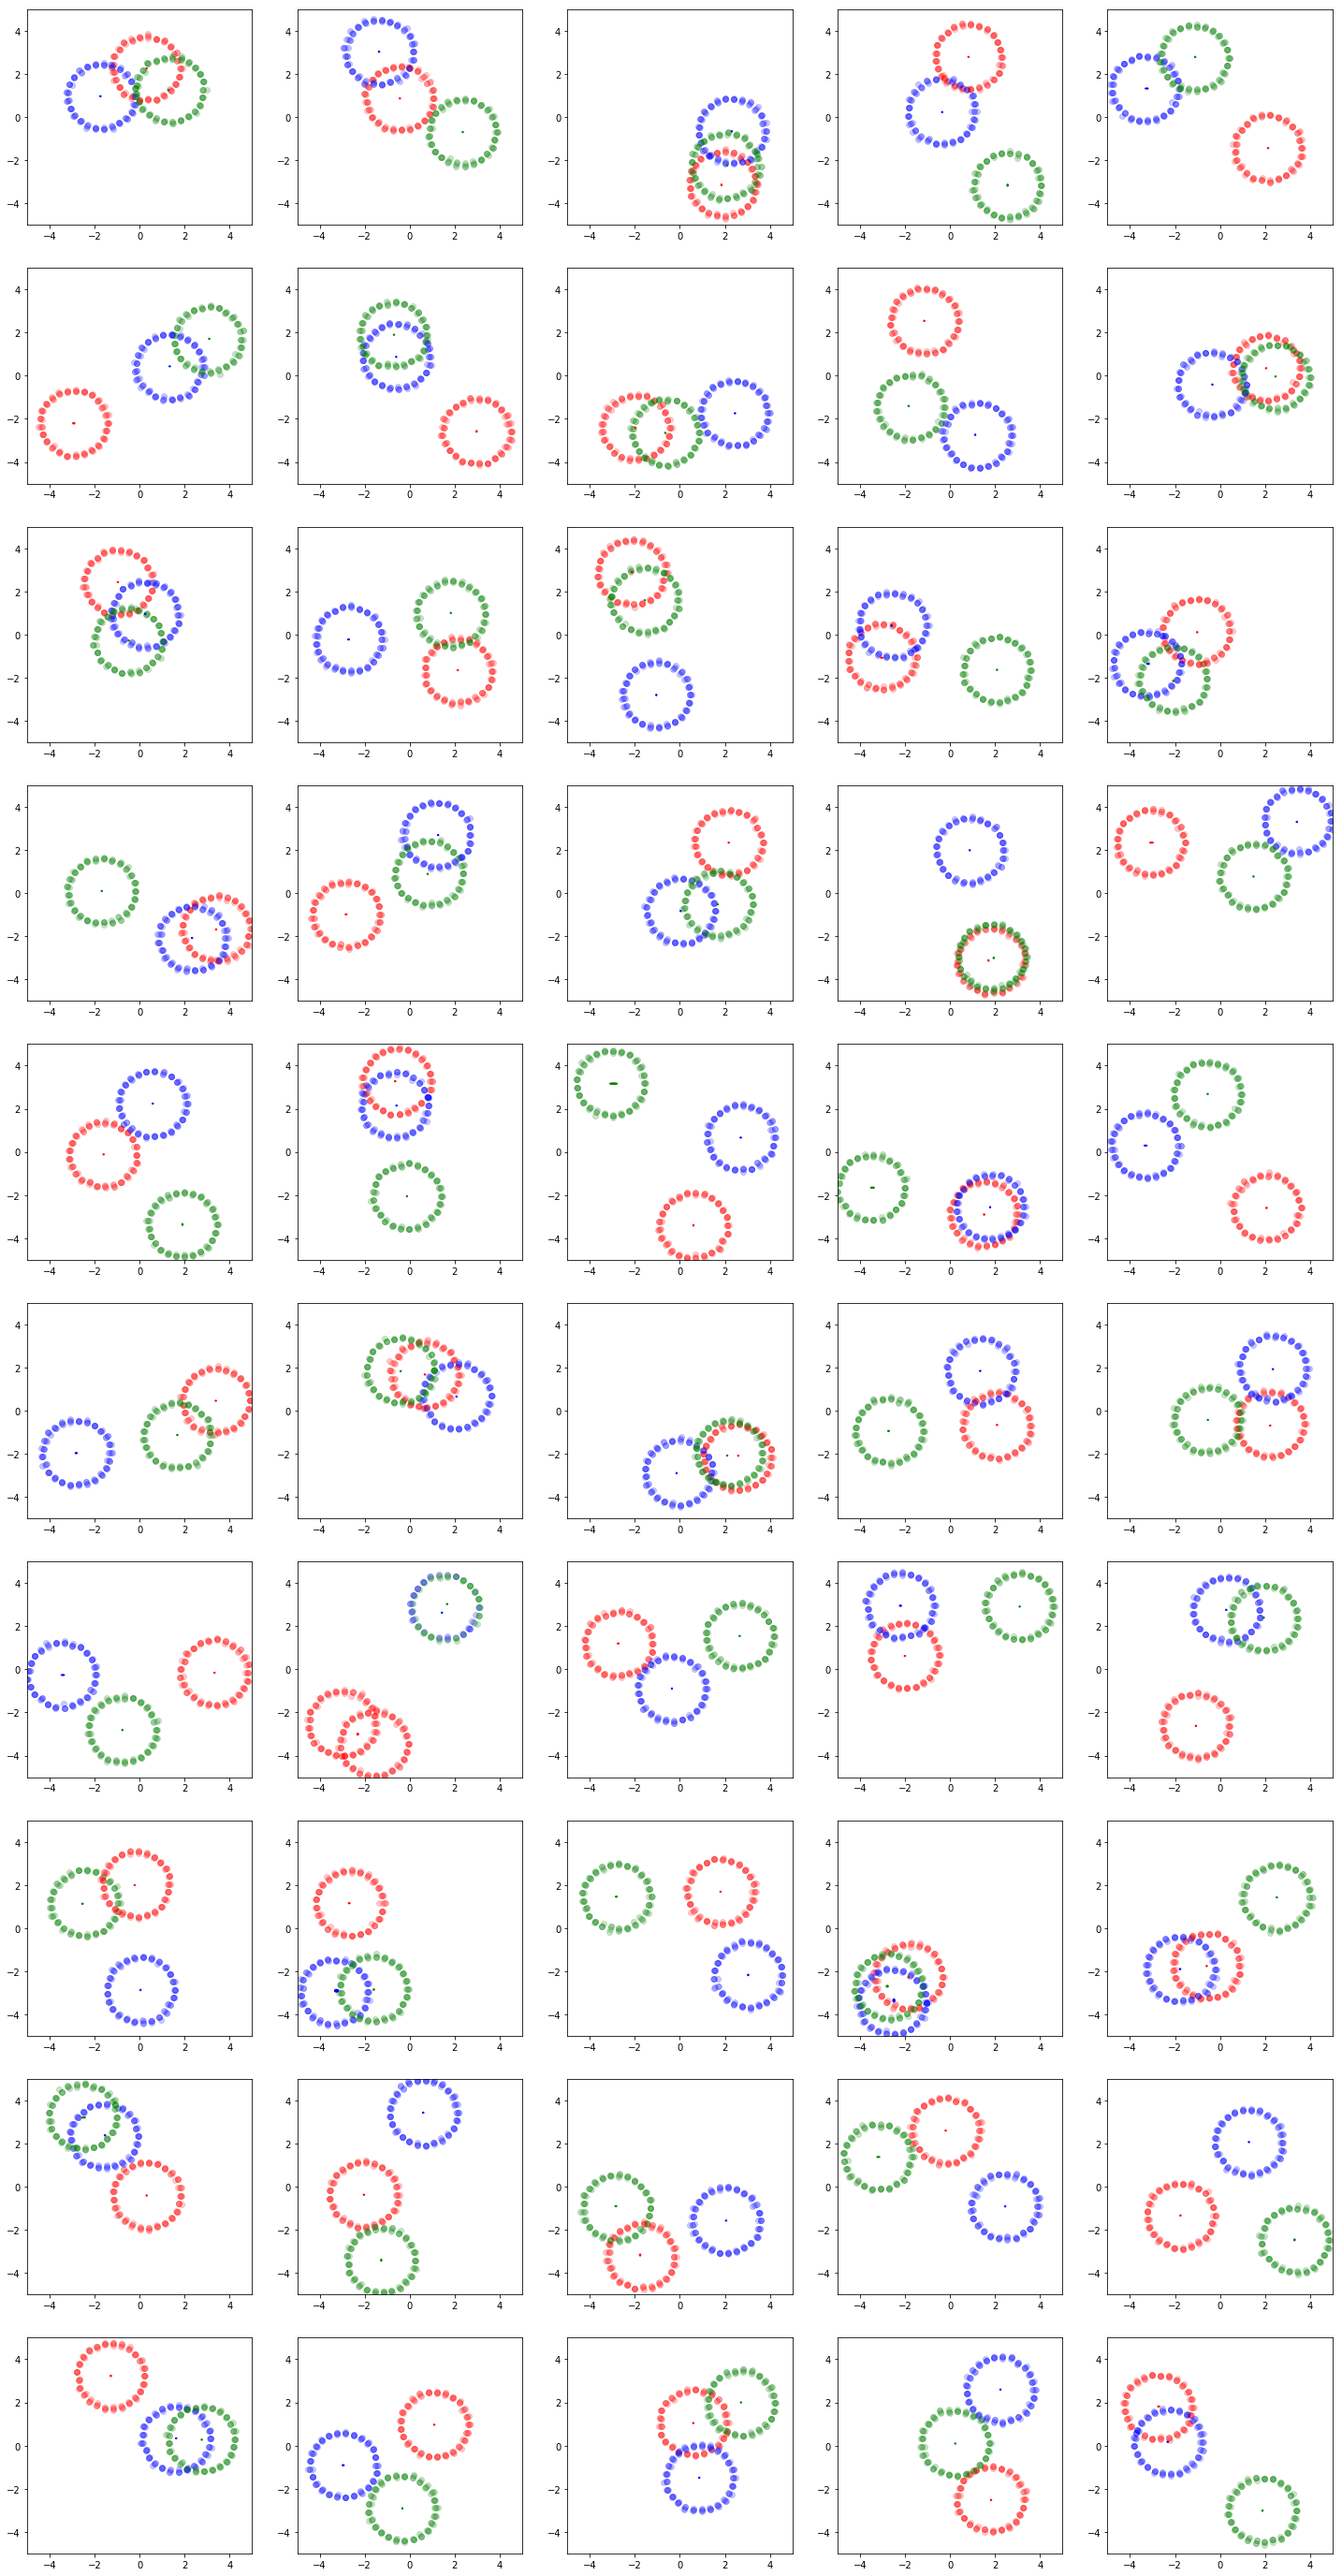

In [11]:
BATCH_SIZE_TEST = 50

def sample_single_batch(num_seqs, N, K, D, sample_size, batch_size, gpu):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    obs = shuffler(obs).repeat(sample_size, 1, 1, 1)
    if CUDA:
        obs = obs.cuda().to(gpu)
    return obs

def test(enc_mu, enc_z, obs, N, K, D, mcmc_size, sample_size, batch_size, gpu):
    p_init_z = cat(prior_pi)
    states = p_init_z.sample((sample_size, batch_size, N,))
    log_p_z = p_init_z.log_prob(states)## S * B * N
    log_q_z = p_init_z.log_prob(states)
    for m in range(mcmc_size):
        q_mu, p_mu = enc_mu(obs, states, sample_size, batch_size)
        log_q_mu = q_mu['means'].log_prob.sum(-1)
        log_p_mu = p_mu['means'].log_prob.sum(-1) # S * B * K
        obs_mu = q_mu['means'].value
        log_obs_k = Log_likelihood(obs, states, obs_mu, K, D, radius=1.5, noise_sigma = 0.05, gpu=gpu, cluster_flag=True)
        log_weights_global = log_obs_k + log_p_mu - log_q_mu
        weights_global = F.softmax(log_weights_global, 0).detach()
        ## resample mu
        obs_mu = resample_mu(obs_mu, weights_global)
        ## update z -- cluster assignments
        q_z, p_z = enc_z(obs, obs_mu, 1.5, 0.05, sample_size, batch_size)
        log_p_z = p_z['zs'].log_prob
        log_q_z = q_z['zs'].log_prob ## S * B * N
        states = q_z['zs'].value
        log_obs_n = Log_likelihood(obs, states, obs_mu, K, D, radius=1.5, noise_sigma = 0.05, gpu=gpu, cluster_flag=False)
        log_weights_local = log_obs_n + log_p_z - log_q_z
        weights_local = F.softmax(log_weights_local, 0).detach()

    return q_mu, q_z

def plot_samples(obs, q_eta, q_z, K, batch_size, PATH):
    colors = ['r', 'b', 'g']
    fig = plt.figure(figsize=(25,50))
    xs = obs[0].cpu()
    mu_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
    mu_sigma = q_eta['means'].dist.scale[0].cpu().data.numpy()
    zs = q_z['zs'].dist.probs[0].cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b]
        z = zs[b]
        mu_mu_b = mu_mu[b]
        mu_sigma_b = mu_sigma[b]
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(mu_sigma_b[k]**2)
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], alpha=0.2)
            plot_cov_ellipse(cov=cov_k, pos=mu_mu_b[k], nstd=2, ax=ax, alpha=1.0, color=colors[k])
        ax.set_ylim([-5, 5])
        ax.set_xlim([-5, 5])
    plt.savefig('results/modes-' + PATH + '.svg')
    
obs = sample_single_batch(NUM_SEQS, N, K, D, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
q_mu, q_z = test(enc_mu, enc_z, obs, N, K, D, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
%time plot_samples(obs, q_mu, q_z, K, BATCH_SIZE_TEST, PATH)